In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random
import matplotlib.pyplot as plt

In [ ]:
%%capture
!pip install torchinfo

# Data Preperation

In [ ]:
def read_file_to_string(file_path):
    with open(file_path, 'r') as file:
        return file.read()

def create_dataset(mapped_ints, seq_length=100):
    dataX = []
    dataY = []
    for i in range(0, len(mapped_ints) - seq_length):
        seq_in = mapped_ints[i:i + seq_length]
        seq_out = mapped_ints[i + seq_length]
        dataX += seq_in
        dataY.append(seq_out)
    n_patterns = len(dataY)
    X = torch.tensor(dataX, dtype=torch.long).view(n_patterns, seq_length)
    y = torch.tensor(dataY, dtype=torch.long)
    return X, y

string = read_file_to_string('input.txt')
letters = list(set(string))
letters.sort()
letter_to_int = {letter: i for i, letter in enumerate(letters)}
int_to_letter = {i: letter for i, letter in enumerate(letters)}
mapped_ints = [letter_to_int[letter] for letter in string]

X, y = create_dataset(mapped_ints, seq_length=100)

# Configuration

In [ ]:
BATCH_SIZE = 32
SEQ_LEN = 100
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
N_VOCAB = len(letters)
ENC_DIM = 8
N_HEADS = 2
DROPOUT = 0.5

Using device: cuda


# Architecture

In [ ]:
class Flatten(torch.nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        batch_size = x.shape[0]
        return x.reshape(batch_size, -1)

class AttentionHead(nn.Module):
    def __init__(self, input_dim, head_sz, linear, masked):
        super(AttentionHead, self).__init__()
        self.q = nn.Linear(input_dim, head_sz)
        self.k = nn.Linear(input_dim, head_sz)
        self.v = nn.Linear(input_dim, head_sz)
        self.head_sz = head_sz
        self.linear = linear
        self.masked = masked
        self.register_buffer('mask', None, persistent=False)

    def get_mask(self, T):
        """
        Generates and caches a triangular mask as a buffer if not already created.
        """
        if self.mask is None or self.mask.size(0) != T:
            mask = torch.tril(torch.ones(T, T, dtype=torch.bool, device=DEVICE))
            self.mask = mask
        return self.mask

    def forward(self, output, input):
        # X's shape is (B, T, C)
        B, T, C = output.shape
        q = self.q(output)  # (B, T, H)
        k = self.k(input)  # (B, T, H)
        v = self.v(input)  # (B, T, H)

        k_T = k.transpose(1, 2)  # (B, H, T)

        # We will just use the linear kernel
        # For similarity calculations for now.
        # We notice this linear transformer does not really
        # provide an improvement because parallelization now is not possible.

        V_tag = []
        if self.linear:
            S, Z = torch.zeros(B, self.head_sz, self.head_sz, device=DEVICE), torch.zeros(B, self.head_sz, 1, device=DEVICE)
            if self.masked:
                for i in range(T):
                    S = S + (k_T[:, :, i:i+1] @ v[:, i:i+1])  # (B, H, 1) @ (B, 1, H) = (B, H, H)
                    Z = Z + (k_T[:, :, i:i+1])  # (B, H, 1)
                    V_tag.append((q[:, i:i+1] @ S) / (q[:, i:i+1] @ Z))
                    # (B, 1, H) @ (B, H, H) / (B, 1, H) @ (B, H, 1) = (B, 1, H)
                V_tag = torch.cat(V_tag, dim=1).to(DEVICE)
            else:
                S = k_T @ v  # (B, H, T) @ (B, T, H) = (B, H, H)
                Z = k_T.sum(dim=-1)  # (B, H, T)
                V_tag = (
                    (q @ S) / (q @ Z)
                )  # (B, T, H) @ (B, H, H) / (B, T, H) @ (B, H, 1) = (B, T, H)
        else:
            if self.masked:
                V_tag = F.scaled_dot_product_attention(q, k, v, attn_mask=self.get_mask(T))
            else:
                V_tag = F.scaled_dot_product_attention(q, k, v)

        return V_tag

class MultiHeadedAttention(nn.Module):
    def __init__(self, input_dim, n_heads, linear, masked, dropout):
        super(MultiHeadedAttention, self).__init__()
        self.head_sz = input_dim // n_heads
        self.heads = nn.ModuleList(
            [
                AttentionHead(input_dim=input_dim, head_sz=self.head_sz, linear=linear, masked=masked)
                for _ in range(n_heads)
            ]
        )
        self.bn = nn.BatchNorm1d(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, output, input):
        # Should learn how to parallelize this
        out = []
        for head in self.heads:
            head_output = head(output, input)
            out.append(head_output)  # (B, T, head_sz)
        out = torch.cat(out, dim=2)  # (B, T, head_sz * n_heads = input_dim)
        return self.dropout(out)

class FeedForwardLayer(nn.Module):
    def __init__(self, input_dim, output_dim, dropout):
        super(FeedForwardLayer, self).__init__()
        self.linear1 = nn.Linear(input_dim, 4 * input_dim)
        self.linear2 = nn.Linear(4 * input_dim, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, input):
        output = self.linear1(input)
        output = self.dropout(output)
        output = self.relu(output)
        output = self.dropout(output)
        output = self.linear2(output)
        return output

class AddNorm(nn.Module):
    def __init__(self, output_dim: int, module: nn.Module):
        super(AddNorm, self).__init__()
        self.bn = nn.BatchNorm1d(output_dim)
        self.module = module

    def forward(self, **kwargs):
        x = self.module(**kwargs) + kwargs[next(iter(kwargs))]
        x = x.transpose(1, 2)
        return self.bn(x).transpose(1, 2)

class TransformerLayer(nn.Module):
    def __init__(self, input_dim, output_dim, linear, n_heads, dropout):
        super(TransformerLayer, self).__init__()
        self.masked_attn = AddNorm(
            input_dim, MultiHeadedAttention(input_dim=input_dim, n_heads=n_heads, linear=linear, masked=True, dropout=dropout)
        )
        self.cross_attn = AddNorm(
            input_dim, MultiHeadedAttention(input_dim=input_dim, n_heads=n_heads, linear=linear, masked=False, dropout=dropout)
        )
        self.attn = AddNorm(
            input_dim, MultiHeadedAttention(input_dim=input_dim, n_heads=n_heads, linear=linear, masked=False, dropout=dropout)
        )
        self.input_ff = AddNorm(
            input_dim, FeedForwardLayer(input_dim=input_dim, output_dim=input_dim, dropout=dropout)
        )
        self.output_ff = AddNorm(
            input_dim, FeedForwardLayer(input_dim=input_dim, output_dim=input_dim, dropout=dropout)
        )
        self.fin_linear = nn.Linear(input_dim, output_dim)

    def forward(self, input, output):
        output = self.masked_attn(output=output, input=output)
        input = self.attn(output=input, input=input)
        input = self.input_ff(input=input)
        output = self.cross_attn(output=output, input=input)
        output = self.output_ff(input=output)
        output = self.fin_linear(output)
        return output

class TransformerDecoderLayer(nn.Module):
    def __init__(self, input_dim, output_dim, linear, n_heads, dropout):
        super(TransformerDecoderLayer, self).__init__()
        self.masked_attn = AddNorm(
            input_dim, MultiHeadedAttention(input_dim=input_dim, n_heads=n_heads, linear=linear, masked=True, dropout=dropout)
        )
        self.output_ff = AddNorm(
            input_dim, FeedForwardLayer(input_dim=input_dim, output_dim=input_dim, dropout=dropout)
        )

    def forward(self, output):
        output = self.masked_attn(output=output, input=output)
        output = self.output_ff(input=output)
        return output

class TransformerModel(nn.Module):
    def __init__(self, input_dim, n_vocab, linear, n_heads, dropout):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(n_vocab, input_dim)
        self.transformer_layer1 = TransformerDecoderLayer(input_dim=input_dim, output_dim=n_vocab, linear=linear, n_heads=n_heads, dropout=dropout)
        self.transformer_layer2 = TransformerDecoderLayer(input_dim=input_dim, output_dim=n_vocab, linear=linear, n_heads=n_heads, dropout=dropout)
        self.fin_linear = nn.Linear(input_dim, n_vocab)

    def forward(self, input):
        output = self.embedding(input)
        output = self.transformer_layer1(output)
        output = self.transformer_layer2(output)
        output = self.fin_linear(output)
        return F.softmax(output, dim=2)

In [ ]:
linear_model = TransformerModel(input_dim=ENC_DIM, n_vocab=N_VOCAB, linear=True, n_heads=N_HEADS, dropout=DROPOUT).to(DEVICE)
softmax_model = TransformerModel(input_dim=ENC_DIM, n_vocab=N_VOCAB, linear=False, n_heads=N_HEADS, dropout=DROPOUT).to(DEVICE)
X = X.to(DEVICE)
y = y.to(DEVICE)

In [ ]:
from torchinfo import summary
summary(linear_model)

Layer (type:depth-idx)                        Param #
TransformerModel                              --
├─Embedding: 1-1                              520
├─TransformerDecoderLayer: 1-2                --
│    └─AddNorm: 2-1                           --
│    │    └─BatchNorm1d: 3-1                  16
│    │    └─MultiHeadedAttention: 3-2         232
│    └─AddNorm: 2-2                           --
│    │    └─BatchNorm1d: 3-3                  16
│    │    └─FeedForwardLayer: 3-4             552
├─TransformerDecoderLayer: 1-3                --
│    └─AddNorm: 2-3                           --
│    │    └─BatchNorm1d: 3-5                  16
│    │    └─MultiHeadedAttention: 3-6         232
│    └─AddNorm: 2-4                           --
│    │    └─BatchNorm1d: 3-7                  16
│    │    └─FeedForwardLayer: 3-8             552
├─Flatten: 1-4                                --
├─Linear: 1-5                                 ***calc again***
Total params: ***calc again***
Trainable para

In [ ]:
linear_optimizer = optim.AdamW(linear_model.parameters(), lr=5e-4)
softmax_optimizer = optim.AdamW(softmax_model.parameters(), lr=5e-4)
scheduler_lm = ReduceLROnPlateau(linear_optimizer, mode='min', factor=0.7, patience=10000, verbose=True)
scheduler_sm = ReduceLROnPlateau(softmax_optimizer, mode='min', factor=0.7, patience=10000, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


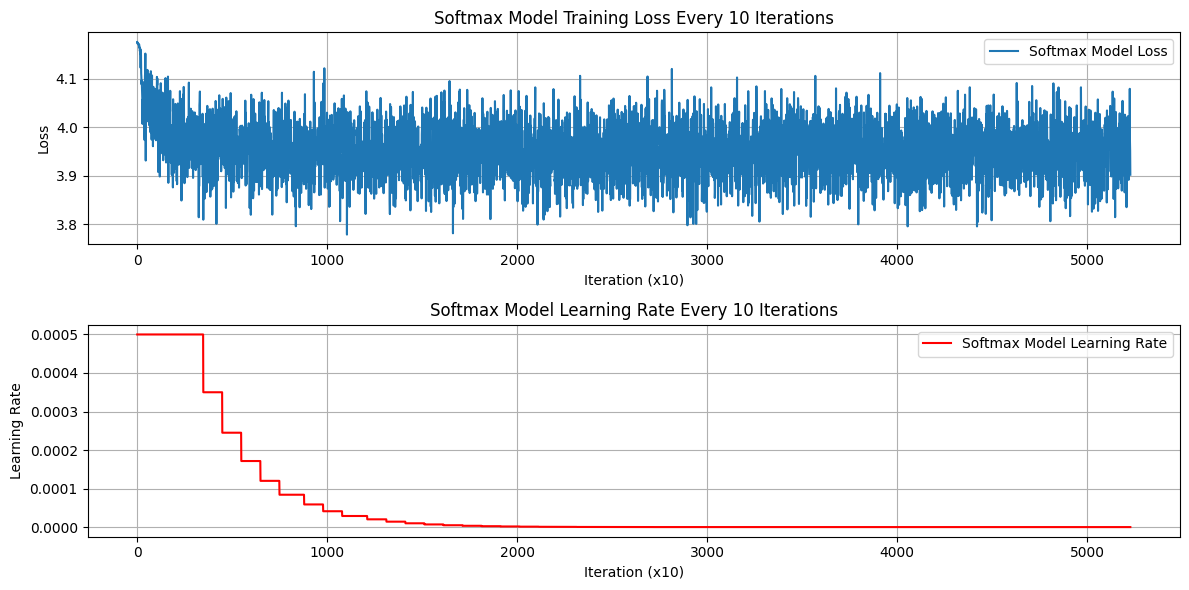

In [ ]:
criterion = nn.CrossEntropyLoss()

# Training loop
def train_model(model, optimizer, scheduler, model_name, epochs=3):
    loss_history = []  # To store loss values for plotting
    lr_history = []    # To store learning rate values for plotting
    iteration_count = 0

    for epoch in range(epochs):
        # Shuffle the dataset
        indices = list(range(len(X)))
        random.shuffle(indices)
        X_shuffled = X[indices]
        y_shuffled = y[indices]

        for i in range(0, len(X_shuffled) - 100, 64):  # Batch size of 64
            inputs = X_shuffled[i:i + 64]
            labels = y_shuffled[i:i + 64]

            optimizer.zero_grad()
            outputs = model(inputs)  # Model's predictions
            one_hot_labels = F.one_hot(labels, num_classes=65).float()
            loss = criterion(outputs.view(-1, 65), one_hot_labels.float())

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            scheduler.step(loss)

            # Record loss and learning rate every 10 iterations
            if iteration_count % 10 == 0:
                loss_history.append(loss.item())
                lr_history.append(optimizer.param_groups[0]['lr'])  # Store current learning rate

            iteration_count += 1
    # Plotting the loss and learning rate history
    plt.figure(figsize=(12, 6))

    # Plot Loss
    plt.subplot(2, 1, 1)  # Subplot for Loss
    plt.plot(range(len(loss_history)), loss_history, label=f'{model_name} Loss')
    plt.xlabel('Iteration (x10)')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Training Loss Every 10 Iterations')
    plt.legend()
    plt.grid(True)

    # Plot Learning Rate
    plt.subplot(2, 1, 2)  # Subplot for Learning Rate
    plt.plot(range(len(lr_history)), lr_history, label=f'{model_name} Learning Rate', color='red')
    plt.xlabel('Iteration (x10)')
    plt.ylabel('Learning Rate')
    plt.title(f'{model_name} Learning Rate Every 10 Iterations')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Train the models with model names
train_model(softmax_model, softmax_optimizer, scheduler_sm, model_name="Softmax Model")
# train_model(linear_model, linear_optimizer, scheduler_lm, model_name="Linear Model")

In [ ]:
plt.show()